# Creating a BERT-like transformer



## Instructions

The notebook has been implemented to require the user to write their own code. Normal descriptive information is in plain text.

> Any text within a quote block indicates instructions for the user.

## Bidirectional Encoder Representations from Transformers (BERT)

The BERT model consists of multiple transformer layers, where each layer is composed of multi-head self-attention and point-wise feedforward networks. The input to the model is a sequence of word-piece tokens, which are first passed through an embedding layer to generate dense vector representations of each token. These embeddings are then fed to the input of the first transformer layer. The output of the last transformer layer is then used as input to a task-specific layer, which can be a simple linear layer for classification tasks or a sequence labeling layer for sequence tagging tasks, among others.

### Transformer layer in BERT

The following are the contents of a single BERT transformer layer:

1. __Multi-Head Self-Attention__: This sublayer consists of multiple parallel attention mechanisms (heads) that attend to different parts of the input sequence. The output of each head is concatenated and then passed through a linear projection to produce a single attention vector for each input token.

2. __Layer Normalization__: This sublayer normalizes the outputs of the self-attention sublayer across the hidden dimension. Specifically, it applies a normalization operation that scales and shifts the outputs to have zero mean and unit variance.

3. __Point-wise Feedforward Network__: This sublayer applies a fully connected feedforward network to each position in the sequence independently. The output of this sublayer is a new set of hidden representations for each position.

4. __Another Layer Normalization__: As in step 2, this sublayer normalizes the outputs of the feedforward sublayer across the hidden dimension.

5. __Skip Connection and Residual Connection__: This sublayer adds the output of the feedforward sublayer to the original input embeddings and applies a residual connection. This allows the model to directly incorporate the original input embeddings into the final output of the layer.

Note that the output of each transformer layer is a sequence of hidden representations that are passed to the next layer in the stack. In BERT, multiple transformer layers are stacked on top of each other to form a deep neural network. The final output of the BERT model is typically the output of the last transformer layer, which can be used for downstream tasks such as text classification, named entity recognition, and question answering.

### Differences between the BERT and the original transformer

BERT (Bidirectional Encoder Representations from Transformers) is a variation of the original "Attention is All You Need" transformer model. The core idea behind both models is the same, i.e., to use self-attention to model the relationships between different positions in a sequence. Both models were initially trained with MLM as well.

However, BERT introduces several key modifications to the original transformer architecture that make it more effective for tasks such as natural language understanding.

The original transformer was designed as an encoder-decoder model for machine translation, where the encoder takes in the source language sentence and produces a sequence of hidden states, and the decoder takes in these hidden states and generates the target language sentence. However, BERT is not an encoder-decoder model like the original transformer. Instead, BERT is an encoder-only model. BERT also incorporates masked attention, where the inputs are corrupted by random masking (think dropout).


### Positional embedding instead of encoding

The positional encoding (PE) scheme used in BERT is not the same as the original transformer model. In the original transformer model, the PE vectors are calculated based on a fixed function that is defined separately from the model itself. Specifically, for each position in the input sequence, the PE vector is calculated based on a fixed set of sinusoidal functions with different frequencies and phases. The frequencies and phases are pre-defined and do not change during training.

In contrast, in BERT, the PE vectors are learned during the model training process making them positional embeddings instead of just encodings. Specifically, the PE vectors are initialized randomly and then fine-tuned along with the rest of the model parameters during the pre-training process. This allows the model to learn a more task-specific representation of the position information that is optimal for the downstream task.

Another difference between BERT and the original transformer in terms of positional encoding is the way in which the position information is combined with the token embeddings. In the original transformer, the PE vectors are added directly to the token embeddings, while in BERT, the PE vectors are added after the token embeddings are passed through a layer normalization step. This means that the PE vectors in BERT have access to the normalized embeddings, which can help to mitigate the effect of covariate shift during training.

## Loading the data

Loading the data is the first step in any data-driven machine learning project. In this case, we will use the Python pandas library to read in the training and validation data from their respective CSV files using the ``pd.read_csv()`` function. The data is expected to be stored in the specified file locations relative to the current working directory.

> Load the training and validation CSVs from the data folder to `df_train` and `df_validation`:
> - Training CSV path: 
>   - Local: `"../../data/train.csv"`
>   - Colab: `"./data/train.csv"`
> - Validation CSV path:
>   - Local: `"../../data/validation.csv"`
>   - Colab: `"./data/validation.csv"`
>
> NOTE: For Colab, the data has been downloaded from the [karmus89/transformers-seminar-workshop](https://github.com/karmus89/transformers-seminar-workshop) Github repo and all preprocessing is done and naming is predetermined.

In [1]:
import pandas as pd

df_train = pd.read_csv("../../data/train.csv", index_col=0)
df_validation = pd.read_csv("../../data/validation.csv", index_col=0)

In [ ]:
# Don't remove this cell
print(f"Data columns: {df_train.columns}")
df_train.head()

__Pay attention to the data above.__

## Creating the embeddings

First thing to do is to create our own embeddings and the embedding layer.

### Creating the vocabulary

In order to use an embedding layer, we'll first need to create our own vocabulary. This involves tokenizing our text data into a sequence of tokens and assigning a unique index to each token in the vocabulary. Creating the vocabulary is an important step in any natural language processing (NLP) project. In this case, we will create a vocabulary from the training data that will be used to convert the text into a numerical format that can be fed into the BERT model.

Next we extract the unique tokens from the training data and create a vocabulary for use in the BERT model. The resulting vocabulary will be used to map each word in the text data to a unique numerical ID, which will be used as input to the BERT model.

> Retrieve unique tokens from the training DataFrame's `transcription` column. Persist the unique tokens to a variable named ``unique_tokens``.

In [2]:
unique_tokens = set()
for i, row in df_train.iterrows():
    input_ids = row["transcription"].split(" ")
    for token in input_ids:
        unique_tokens.add(token)

print(f"Unique tokens: {len(unique_tokens)}")
unique_tokens = list(unique_tokens)

Unique tokens: 18143


In [ ]:
# Don't remove this cell
assert len(unique_tokens) < 25000

Next we will create a mapping from each unique token to a unique integer ID, which will be used to represent the token in the numerical format. 

We start by defining several special tokens that are commonly used in NLP tasks, including the classification token ``[CLS]``, the separator token ``[SEP]``, the unknown token ``[UNK]``, and the padding token ``[PAD]``. These tokens will be added to the beginning of the vocabulary along with the unique tokens extracted from the training data.

In [ ]:
# Don't remove this cell
cls_token = "[CLS]"
sep_token = "[SEP]"
unknown_token = "[UNK]"
padding_token = "[PAD]"

> Create a dictionary called ``vocabulary``, where keys are the unique tokens and values are unique integer indices. Also add the special tokens to the dictionary.

In [5]:
vocabulary = {}
idx = 0
input_ids = [cls_token, sep_token, unknown_token, padding_token] + unique_tokens
for token in input_ids:
    vocabulary[token] = idx
    idx += 1

In [6]:
# Don't remove this cell
assert cls_token in vocabulary.keys()
assert sep_token in vocabulary.keys()
assert unknown_token in vocabulary.keys()
assert padding_token in vocabulary.keys()
assert len(vocabulary) == len(unique_tokens) + 4

### Mapping tokens to indices

Next, we will map each token in the text data to its corresponding index in the vocabulary. To achieve this, we will define two functions.

 - ``map_token_to_vocabulary_index()``: takes a single token as input and returns the index of the token in the vocabulary dictionary. If the token is not present in the vocabulary, the function returns the index of the unknown token ``[UNK]``.

 - ``map_seq_to_vocabulary()``: takes a string of text as input, splits it into individual tokens, and applies the ``map_token_to_vocabulary_index()`` function to each token using the built-in ``map()`` function. This function returns a list of vocabulary indices corresponding to each token in the input text.

These functions rely on the ``vocabulary`` dictionary that was created in the previous step, which maps each token to a unique numerical ID. The resulting list of vocabulary indices can be used as input to the BERT model, where each index corresponds to a particular token in the input text.

This step is important as it allows us to convert the raw text data into a numerical format that can be fed into the BERT model. The resulting numerical sequences will be used as input to the BERT model during both the pre-training and fine-tuning stages.

In [7]:
# Don't remove this cell
def map_token_to_vocabulary_index(token: str):
    try:
        idx = vocabulary[token]
    except KeyError:
        idx = vocabulary[unknown_token]
    return idx


def map_seq_to_vocabulary(text: str):
    tokens = text.split(" ")
    return list(map(map_token_to_vocabulary_index, tokens))

> Create a new column called ``input_ids`` to training and validation DataFrames by applying the ``map_seq_to_vocabulary`` to each transcription.

In [8]:
df_train["input_ids"] = df_train["transcription"].apply(map_seq_to_vocabulary)
df_validation["input_ids"] = df_validation["transcription"].apply(map_seq_to_vocabulary)

### Padding and trimming to max length

The next step is to prepare the numerical sequences of token indices for input to the BERT model. To do this, we will define a function that will trim or pad each sequence to a fixed maximum length.

This function is important as it allows us to ensure that each input sequence to the BERT model has the same length, which is required for efficient batch processing during training. By trimming or padding each sequence to a fixed length, we can ensure that all sequences can be processed efficiently in parallel by the BERT model.

In [9]:
# Don't remove this cell
MAX_LEN = 128

The function, called ``trim_or_pad()``, takes a list of numerical indices as input and performs the following operations:

1. Inserts the index of the classification token ``[CLS]`` at the beginning of the sequence.
1. If the sequence length is greater than the maximum length ``MAX_LEN``, it trims the sequence to the maximum length by discarding tokens from the end of the sequence.
1. Replaces the last token in the sequence with the index of the separator token ``[SEP].``
1. If the sequence length is less than the maximum length, it pads the sequence with the index of the padding token ``[PAD]`` to the maximum length.
1. The ``MAX_LEN`` parameter is a fixed maximum sequence length that we have chosen for the BERT model. Any sequences longer than ``MAX_LEN`` will be trimmed, and any sequences shorter than ``MAX_LEN`` will be padded.

In [10]:
# Don't remove this cell
def trim_or_pad(indices: list):
    cls_idx = vocabulary[cls_token]
    indices.insert(0, cls_idx)

    if len(indices) > MAX_LEN:
        indices = indices[:MAX_LEN]

    sep_idx = vocabulary[sep_token]
    indices[-1] = sep_idx

    padding_idx = vocabulary[padding_token]
    if len(indices) < MAX_LEN:
        padding = MAX_LEN - len(indices)
        indices = indices + [padding_idx] * padding

    return indices

> Apply the ``trim_or_pad`` function to the ``input_ids`` column of training and validation DataFrames by replacing the old values with new ones.

In [11]:
df_train["input_ids"] = df_train["input_ids"].apply(trim_or_pad)
df_validation["input_ids"] = df_validation["input_ids"].apply(trim_or_pad)
df_train["input_ids"].head()

204     [0, 17411, 6715, 13624, 8496, 10384, 16222, 10...
1561    [0, 3027, 4058, 16860, 5888, 12802, 10115, 102...
1564    [0, 3027, 4058, 3361, 3394, 7239, 11217, 7459,...
1072    [0, 17411, 6715, 16860, 15385, 188, 18014, 688...
4193    [0, 11674, 17602, 2373, 11451, 14620, 12339, 1...
Name: input_ids, dtype: object

In [12]:
# Don't remove this cell
import numpy as np

assert np.array(df_train["input_ids"].values.tolist()).shape[1] == MAX_LEN

After mapping the tokens to their corresponding indices in the vocabulary and applying padding and trimming to the sequences, we have now prepared our data to be fed into the BERT model.

### Defining the embedding layer
Now that we have processed our data accordinly, we will define an embedding layer that will be responsible for mapping the input tokens to continuous vector representations that can be processed by our neural network.

The original BERT model was trained to perform two tasks at the same time:
1. Masked language modelling
1. Next sentence prediction

This means that the model was fed two sentences at a time that either did or did not relate to each other, while having some tokens randomly assigned the value of the ``[MASK]`` token. Because we are trying to work out a basic case for a transformer, we will only stick to MLM. This is why, for the embedding, we will only embed the tokens and the positions, but omit the sequence embeddings.

The embedding layer will be implemented as a PyTorch module that extends the ``nn.Module`` class. We will initialize the module with the size of the vocabulary and the desired dimensionality of the embedding vectors. The module will use PyTorch's built-in ``nn.Embedding`` class to perform the embedding, which will allow us to easily update the embedding weights during training. The module will also handle padding tokens by setting their embeddings to all zeros. Finally, we will define a forward method for the module that takes a tensor of input token indices and returns a tensor of embedded vectors.

> Define a PyTorch module ``TranscriptionEmbedding`` that takes in ``vocab_size``, ``max_seq_len``, and ``embedding_size`` as arguments, and produces embedded tokens with the ``forward`` method. The module should use an embedding layer to create token embeddings for the vocabulary and another embedding layer to create positional embeddings for tokens in a sequence. The ``forward`` method of the module should take ``input_ids`` as input and return the embeddings after adding token embeddings and positional embeddings. The position embeddings should be calculated from position indices that correspond to the ``max_seq_len``.

In [13]:
import torch
import torch.nn as nn


class TranscriptionEmbedding(nn.Module):
    def __init__(self, vocab_size, max_seq_len, embedding_size):
        super().__init__()

        self.num_positions = max_seq_len

        # Embedding layers
        self.token_embedding = nn.Embedding(vocab_size, embedding_size)
        self.position_embedding = nn.Embedding(max_seq_len, embedding_size)

    def forward(self, input_ids):
        # Get position ids for the input sequence
        position_ids = torch.arange(
            self.num_positions, dtype=torch.long, device=input_ids.device
        )
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        # Apply token and positional embeddings
        token_embeddings = self.token_embedding(input_ids)
        position_embeddings = self.position_embedding(position_ids)

        embeddings = token_embeddings + position_embeddings

        return embeddings

Let's create an instance of the ``TranscriptionEmbedding`` module and feed it some data to see what it does.

> Initialize a ``TranscriptionEmbedding`` class with. Feed it a single sequence from the ``input_ids`` column and examine the shape and the contents of the embedded sample.

In [14]:
embedding = TranscriptionEmbedding(
    vocab_size=len(vocabulary), max_seq_len=MAX_LEN, embedding_size=64
)
sample = torch.tensor([df_train["input_ids"].values[0]])
embedded_sample = embedding(sample)
print(f"Embedding output shape: {embedded_sample.shape}")
embedded_sample

Embedding output shape: torch.Size([1, 128, 64])


tensor([[[ 1.2236, -0.1258, -2.0221,  ..., -0.4177, -1.3927, -0.1547],
         [-0.0851,  1.3601,  0.9648,  ...,  1.3672,  0.8074,  3.6330],
         [-5.0818, -0.1715, -0.1362,  ...,  0.8627,  1.8730, -0.6760],
         ...,
         [ 0.8403,  2.1501, -0.0781,  ...,  0.0105,  1.3463, -0.3644],
         [ 1.0907, -0.7631, -0.0083,  ...,  0.9650,  2.3691, -1.1097],
         [-1.2586,  1.4876,  0.0936,  ...,  2.2037, -0.7767,  1.8996]]],
       grad_fn=<AddBackward0>)

## Creating the BERT-like transformer

Now we can move on to creating all the necessary components of a complete BERT-like transformer model:
 - Multi-head attention module
 - Single transformer layer

With these and the previously defined embedding module, we'll finally create a BERT-like multi-layer transformer model.

### Masking padding tokens for attention

As we've had to pad shorter sequences, we must be able to inform our multi-head self-attention mechanism about the padding tokens that do not actually contribute anything. Let's next create masks for non-padding tokens.

> Create a new column ``attention_mask`` to the DataFrames by creating new boolean sequences for whether a token in a sequence is padding token or not. As the aim is to create a mask _for_ attention, the masking sequence should contain ``True`` for each non-padding token and ``False`` for each padding token.


In [15]:
padding_idx = vocabulary[padding_token]
df_train["attention_mask"] = df_train["input_ids"].apply(
    lambda tokens: [token != padding_idx for token in tokens]
)
df_validation["attention_mask"] = df_validation["input_ids"].apply(
    lambda tokens: [token != padding_idx for token in tokens]
)

[Text(0.5, 1.0, 'Trimmed sequences with padding (black)')]

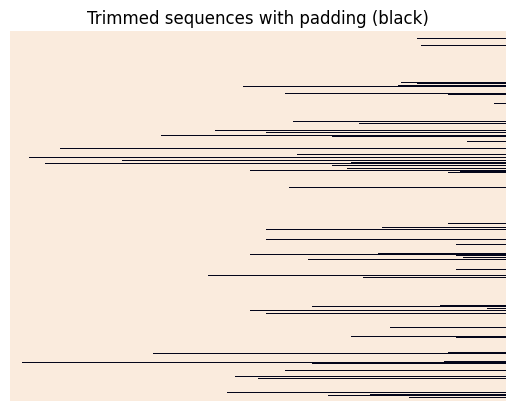

In [16]:
# Don't remove this cell
import seaborn as sns
import numpy as np

mask_arr = np.array(df_train[["attention_mask"]].values.tolist()).squeeze(1)
assert mask_arr.shape[1] == MAX_LEN
sns.heatmap(mask_arr, cbar=False, xticklabels=[], yticklabels=[]).set(
    title="Trimmed sequences with padding (black)"
)

### Multi-head self-attention

Next, we'll define a PyTorch module that implements the multi-head self-attention mechanism used in BERT. This module will take as input the hidden size and number of attention heads. 

It will consist of four linear projections that transform the input embeddings into query, key, and value representations that will be used to compute attention scores. The module will split the query, key, and value representations into multiple heads, and apply the attention mechanism separately to each head in parallel. The module will then combine the outputs of the attention heads and pass them through a linear projection to obtain the final output. The module will also include an optional attention mask that can be used to exclude certain positions from the attention calculation. 

We will then use this module as part of our BERT-like transformer neural network to enable the network to focus on different parts of the input sequence with different levels of attention.

In [17]:
# Don't remove this cell
import torch
import torch.nn as nn


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads

        # Linear projections
        self.query_linear = nn.Linear(hidden_size, hidden_size)
        self.key_linear = nn.Linear(hidden_size, hidden_size)
        self.value_linear = nn.Linear(hidden_size, hidden_size)

        # Output projection
        self.output_linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, input_tensor, attention_mask=None):
        batch_size, seq_length, hidden_size = input_tensor.size()

        # Project inputs to queries, keys, and values
        query = self.query_linear(input_tensor)
        key = self.key_linear(input_tensor)
        value = self.value_linear(input_tensor)

        # Split heads
        query = query.view(
            batch_size, seq_length, self.num_heads, hidden_size // self.num_heads
        )
        key = key.view(
            batch_size, seq_length, self.num_heads, hidden_size // self.num_heads
        )
        value = value.view(
            batch_size, seq_length, self.num_heads, hidden_size // self.num_heads
        )

        # Transpose to get dimensions [batch_size, num_heads, seq_length, hidden_size // num_heads]
        query = query.transpose(1, 2)
        key = key.transpose(1, 2)
        value = value.transpose(1, 2)

        # Compute attention scores
        scores = torch.matmul(query, key.transpose(-2, -1))
        scores = scores / (hidden_size // self.num_heads) ** 0.5

        if attention_mask is not None:
            scores = scores.masked_fill(attention_mask.unsqueeze(1).unsqueeze(2), -1e9)

        # Apply softmax to obtain attention weights
        weights = nn.Softmax(dim=-1)(scores)

        # Apply attention weights to values
        context = torch.matmul(weights, value)

        # Concatenate heads and apply output projection
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_length, -1)
        output = self.output_linear(context)

        return output

This module takes an input tensor of shape ``(batch_size, seq_length, hidden_size)`` and applies multi-head self-attention to the input. The ``hidden_size`` parameter determines the dimensionality of the input and output tensors, and the ``num_heads`` parameter determines the number of parallel attention mechanisms (heads) to use.

The module first projects the input tensor to query, key, and value vectors using linear projection layers. It then splits the query, key, and value vectors into multiple heads using the ``view()`` method and transposes the resulting tensor so that the head dimension comes before the sequence and hidden dimensions.

The module then computes attention scores by taking the dot product of the query and key tensors, scaling the result by the square root of the hidden size, and applying a mask to the scores to prevent attending to padding tokens. The module applies a softmax function to the attention scores along the head and sequence dimensions to obtain attention weights for each token in the sequence.

The module then multiplies the attention weights by the value vectors, concatenates the resulting tensor along the head dimension, and passes the result through a linear projection layer to obtain the output tensor.

> Extract a sample and its corresponding attention mask from the training DataFrame. Embed the sample and feed it to a ``MultiHeadSelfAttention`` instance with the attention mask. Examine the shapes and the outputs to get a grasp of what's happening.

In [18]:
sample = torch.tensor([df_train["input_ids"].values[0]])
print(f"Input sample: {sample.shape}")

mask = torch.tensor([df_train["attention_mask"].values[0]])
print(f"Input mask: {mask.shape}")

embedding = TranscriptionEmbedding(
    vocab_size=len(vocabulary), max_seq_len=MAX_LEN, embedding_size=64
)
attention = MultiHeadSelfAttention(hidden_size=64, num_heads=4)

embedded_sample = embedding(sample)
print(f"Embedded input sample: {embedded_sample.shape}")

output = attention(embedded_sample, mask)
print(f"Multi-head attention output: {output.shape}")
output

Input sample: torch.Size([1, 128])
Input mask: torch.Size([1, 128])
Embedded input sample: torch.Size([1, 128, 64])
Multi-head attention output: torch.Size([1, 128, 64])


tensor([[[ 0.1464,  0.1402, -0.0045,  ..., -0.0572,  0.1346,  0.2165],
         [ 0.1464,  0.1402, -0.0045,  ..., -0.0572,  0.1346,  0.2165],
         [ 0.1464,  0.1402, -0.0045,  ..., -0.0572,  0.1346,  0.2165],
         ...,
         [ 0.1464,  0.1402, -0.0045,  ..., -0.0572,  0.1346,  0.2165],
         [ 0.1464,  0.1402, -0.0045,  ..., -0.0572,  0.1346,  0.2165],
         [ 0.1464,  0.1402, -0.0045,  ..., -0.0572,  0.1346,  0.2165]]],
       grad_fn=<ViewBackward0>)

### Transformer layer

Then we'll define a PyTorch module that implements a single transformer layer used in the BERT-like transformer neural network. This module will take as input the hidden size, number of attention heads, and size of the feedforward network. 

It will consist of three submodules: a multi-head self-attention submodule, a pointwise feedforward network submodule, and two layer normalization submodules. The multi-head self-attention submodule will apply the multi-head attention mechanism to the input embeddings to compute attention scores and combine information from different parts of the input sequence. The pointwise feedforward network submodule will apply a fully connected feedforward network to each position in the sequence to capture non-linear relationships between the input embeddings. The two layer normalization submodules will normalize the outputs of the multi-head self-attention and pointwise feedforward network submodules to ensure that the hidden states are centered and scaled. 

We will then use this module as a building block to create a stack of transformer layers that can process the input sequence and contextualize it.

In [19]:
# Don't remove this cell
import torch
import torch.nn as nn

class TransformerLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, ff_size, dropout_rate):
        super().__init__()

        # Multihead self-attention layer with specified number of heads
        self.multihead_attention = MultiHeadSelfAttention(hidden_size, num_heads)

        # Layer normalization for the first residual connection
        self.layer_norm1 = nn.LayerNorm(hidden_size)

        # Feedforward layer with dropout
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, ff_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(ff_size, hidden_size),
            nn.Dropout(dropout_rate),
        )

        # Layer normalization for the second residual connection
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x, attention_mask=None):
        # Multihead self-attention on the input sequence
        attention_output = self.multihead_attention(x, attention_mask)

        # Residual connection from input sequence to attention output
        residual1_output = x + attention_output

        # Layer normalization on the residual connection
        norm1_output = self.layer_norm1(residual1_output)

        # Feedforward layer on the normalized attention output
        ff_output = self.feed_forward(norm1_output)

        # Residual connection from attention output to feedforward output
        residual2_output = norm1_output + ff_output

        # Layer normalization on the second residual connection
        norm2_output = self.layer_norm2(residual2_output)

        # Return the output of the second layer normalization
        return norm2_output

The ``TransformerLayer`` module takes an input tensor ``x`` of shape ``(batch_size, seq_length, hidden_size)`` and an optional padding mask ``attention_mask`` of shape ``(batch_size, seq_length)``. 

It first applies the multi-head self-attention sublayer to the input tensor, passing the padding mask as an additional argument. It then applies the first layer normalization sublayer, adds the output of the multi-head self-attention sublayer to the input tensor using a skip connection, and applies the second layer normalization sublayer. Finally, it passes the output through the point-wise feedforward sublayer and adds the resulting tensor to the output of the second layer normalization sublayer using another skip connection.

> Extract a sample and its corresponding attention mask from the training DataFrame. Embed the sample and feed it to a ``TransformerLayer`` instance with the attention mask. Examine the shapes and the outputs to get a grasp of what's happening.

In [20]:
sample = torch.tensor([df_train["input_ids"].values[0]])
mask = torch.tensor([df_train["attention_mask"].values[0]])

embedding = TranscriptionEmbedding(
    vocab_size=len(vocabulary), max_seq_len=MAX_LEN, embedding_size=64
)
transformer_layer = TransformerLayer(
    hidden_size=64, num_heads=4, ff_size=128, dropout_rate=0.15
)

embedded_sample = embedding(sample)
output = transformer_layer(embedded_sample, mask)
print(f"Transformer layer output: {output.shape}")
output

Transformer layer output: torch.Size([1, 128, 64])


tensor([[[ 0.2863, -1.6797, -1.2065,  ..., -1.5966, -0.0504,  0.7734],
         [ 0.5151, -0.2991, -0.8001,  ..., -0.1623,  0.7041,  0.1722],
         [ 0.0465,  0.4562,  0.3574,  ...,  0.0291,  1.0814, -0.6917],
         ...,
         [ 0.8532, -0.8486,  0.0725,  ..., -0.4530,  1.3275, -1.4515],
         [-0.6537, -1.0172,  0.4140,  ...,  1.2393,  0.8096,  0.5332],
         [-0.6966, -0.8793,  0.6613,  ...,  0.3501,  0.7890,  1.0967]]],
       grad_fn=<NativeLayerNormBackward0>)

### BERT-like transformer

Finally, we'll define a PyTorch module that implements a BERT-like transformer neural network. This module will take as input the vocabulary size, number of classes, hidden size, number of layers, number of attention heads, size of the feedforward network, and maximum sequence length. 

It will consist of four submodules: an embedding layer, a positional encoding layer, a stack of transformer layers, and a linear classifier layer. The embedding layer will map input tokens to embedding vectors. The positional encoding layer will add positional information to the embeddings to give them a sense of order. The stack of transformer layers will process the sequence of embeddings and contextualize them by applying the multi-head self-attention mechanism and the pointwise feedforward network. Finally, the linear classifier layer will project the final hidden state to a vector of class scores. If labels are provided, the module will return both the logits and the cross-entropy loss. If labels are not provided, the module will only return the logits.

In [21]:
# Don't remove this cell
import torch.nn as nn


class AlmostBERT(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        hidden_size=768,
        num_layers=12,
        num_heads=12,
        ff_size=3072,
        max_len=512,
        dropout_rate=0.15,
    ):
        super().__init__()

        self.embedding = TranscriptionEmbedding(vocab_size, max_len, hidden_size)
        self.transformer_layers = nn.ModuleList(
            [
                TransformerLayer(hidden_size, num_heads, ff_size, dropout_rate)
                for _ in range(num_layers)
            ]
        )
        self.classifier = nn.Linear(hidden_size, num_classes)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, labels=None):
        x = self.embedding(input_ids)
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x, attention_mask)
        x = self.classifier(x[:, 0, :])  # use the first token for classification
        if labels is not None:
            loss = self.loss(x, labels)
            return {"loss": loss, "logits": x}
        return {"logits": x}

In this implementation, we create an instance of the BERT module with the following hyperparameters:

- ``vocab_size``: The size of the vocabulary for the input sequence.
- ``hidden_size``: The dimensionality of the input and output tensors.
- ``num_layers``: The number of transformer layers to stack.
- ``num_heads``: The number of parallel attention mechanisms to use in each transformer layer.
- ``ff_size``: The size of the feedforward network used in each transformer layer.
- ``max_len``: The maximum length of the input sequence.

We first create an input embedding layer using ``TranscriptionEmbedding``. We then create a ``PositionalEncoding`` module that adds position information to the input embeddings.

We then create a stack of transformer layers using ``nn.ModuleList`` and the ``TransformerLayer`` module. We also create an output layer for classification using ``nn.Linear``.

In the ``forward()`` method, we first apply the input embedding and positional encoding to the input tensor. We then apply each of the transformer layers in turn. Finally, we apply the classification layer to the output tensor, using only the first token (the ``[CLS]`` token) for classification.

Note that this implementation is simplified and does not include all of the features of a full BERT model. For example, BERT includes a separate output layer for each token in the input sequence, and uses a more complex classification scheme than the simple linear layer used here. However, this implementation should give you an idea of how to use the ``TransformerLayer`` module to create a BERT-like architecture.

## Training the BERT-like transformer

After having defined our BERT model, it is time to train it. For ease of use, we will use the Hugging Face ``Trainer`` to train the model. This requires that the dataset provides samples as dictionaries with the tensors saved in keys corresponding to our model's `forward()` function's expected argument names. We will then train our model, similarly to how we did it in the fine-tuning part.

### Defining target values

In this step, we define the target values for the classification task. A dictionary ``class_to_label`` is defined to map each class to a numerical label. 

In [22]:
# Don't remove this cell
class_to_label = {
    "Surgery": 0,
    "Radiology": 1,
    "Consult": 2,
    "Cardiovascular": 3,
    "Orthopedic": 4,
    "General Medicine": 5,
}

> Create a new colum ``medical_specialty_label`` to the training and validation DataFrames by mapping the `class_to_label` dictionary to the ``medical_specialty`` column.

In [23]:
df_train["medical_specialty_label"] = df_train["medical_specialty"].map(class_to_label)
df_validation["medical_specialty_label"] = df_validation["medical_specialty"].map(
    class_to_label
)

In [24]:
# Don't remove this cell
assert df_train["medical_specialty_label"].dtype == int

### Defining a classification dataset

Next, we will define a PyTorch dataset for our medical transcription classification task. This dataset will take in our preprocessed data and provide batches of input tokens, attention masks, and corresponding labels for training and evaluation. In essence, it is similar to the datasets we've already defined earlier. This time, however, the dataset parses the data from DataFrames directly.

> Define a ``MedicalTranscriptionDataset`` class that inherits from the ``torch.utils.data.Dataset`` class. In the ``__init__`` method, initialize ``input_ids``, ``attention_mask``, and ``labels`` tensors from the passed dataframe. In the ``__getitem__`` method, return the dictionary containing ``input_ids``, ``attention_mask``, and ``labels``. Return detached clones to ensure that data doesn't get modified in-place. In the ``__len__`` method, return the length of the tokens tensor.

In [25]:
import torch


class MedicalTranscriptionDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        super().__init__()
        self.input_ids = torch.tensor(df["input_ids"].values.tolist()).long()
        self.attention_mask = torch.tensor(df["attention_mask"].values.tolist())
        self.labels = torch.tensor(df["medical_specialty_label"].values.tolist())

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx].clone().detach(),
            "attention_mask": self.attention_mask[idx].clone().detach(),
            "labels": self.labels[idx].clone().detach(),
        }

    def __len__(self):
        return len(self.input_ids)

> Initialize a ``MedicalTranscriptionDataset`` and extract a sample from it. Examine the output.

In [26]:
dataset = MedicalTranscriptionDataset(df=df_train)
sample = dataset[1]
print(f"Sample type: {type(sample)}")
print(f"Sample keys: {sample.keys()}")
sample

Sample type: <class 'dict'>
Sample keys: dict_keys(['input_ids', 'attention_mask', 'labels'])


{'input_ids': tensor([    0,  3027,  4058, 16860,  5888, 12802, 10115, 10243,  3682, 11217,
         14260, 11970,  4816,   222, 13738, 15950, 10302,  5752, 16384,  3394,
         12790,  2325,   408,  6317, 14630,  3992,  9329,   248,  6233,   234,
         14357,  8531, 14228, 10469,  3485,   869,  4700, 10469, 12143,  7224,
          4700, 16766, 14186, 13278,  8307, 12612,  4700,  7549,  3957,  6450,
         16384,  2789,  3648,  4700,  8168, 14217, 15289,   408,  8301,  7224,
          2914, 10949,  6233,   234, 14357,  8531, 10844,  6233,  7432, 14357,
          3530,  9963, 10832, 17831, 13974, 17011,  8389,  4860,    85,  4142,
         17198,  3957, 15613,  6233,  7432, 14357,  4675, 13303,  1403, 10832,
          5723,   744,  2369,  5793, 10483, 13583,  3730,  2318,  9243,  9741,
          8955, 17122,  7988,  1305,  6233,  5129, 14357,  3530, 16196,  6233,
          7432, 14357,  9871, 10293,  8307,  5723, 12359,  9661, 18096, 17593,
          5833, 12341, 12740, 12341, 14

> Initialize a ``BERT`` model and feed it a sample using the arguments of the ``forward`` function. Remember, the model expects a batch of inputs.

In [27]:
model = AlmostBERT(
    vocab_size=len(vocabulary),
    num_classes=len(df_train["medical_specialty_label"].unique()),
    hidden_size=64,
    num_layers=4,
    num_heads=4,
    ff_size=128,
    max_len=MAX_LEN,
    dropout_rate=0.15,
)
model(
    input_ids=sample["input_ids"].unsqueeze(0),
    attention_mask=sample["attention_mask"].unsqueeze(0),
    labels=sample["labels"].unsqueeze(0),
)

{'loss': tensor(2.5847, grad_fn=<NllLossBackward0>),
 'logits': tensor([[-0.2373, -0.4159,  1.2769, -0.4227,  0.1785,  0.6220]],
        grad_fn=<AddmmBackward0>)}

### Training the model

Finally it is time to train the mode. The code snippet below defines the process of training a custom BERT-like model on a medical transcription dataset. The model architecture is defined with hyperparameters such as the vocabulary size, hidden size, number of layers, number of heads, and feedforward size. A ``Trainer`` object is initialized with the model, training dataset, and training arguments such as the batch size, number of epochs, and number of workers. The model is then trained and the trained model is saved to a specified path.

> Define and train your custom ``AlmostBERT`` model using the ``Trainer`` class. The model is trained using a TrainingArguments object that specifies the output directory, batch size, number of epochs, and number of dataloader workers. The dataset used for training is the MedicalTranscriptionDataset defined in the code. 
>
> After training, save the model:
> - Local: `"../../model/custom-bert/model.pt"`
> - Colab: `"./model/custom-bert/model.pt"`

In [28]:
import os
from transformers import TrainingArguments, Trainer

torch.cuda.empty_cache()
trainer = Trainer(
    model=AlmostBERT(
        vocab_size=len(vocabulary),
        num_classes=len(df_train["medical_specialty_label"].unique()),
        hidden_size=256,
        num_layers=12,
        num_heads=8,
        ff_size=512,
        max_len=MAX_LEN,
        dropout_rate=0.15,
    ),
    train_dataset=MedicalTranscriptionDataset(df=df_train),
    args=TrainingArguments(
        output_dir="out",
        per_device_train_batch_size=64,
        num_train_epochs=8,
        dataloader_num_workers=8,
    ),
)
trainer.train()
model_path = f"../../model/custom-bert/model.pt"
# We'll save like any Pytorch model, as the model is not a Hugging Face `PreTrainedModel`
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(trainer.model, model_path)

/home/grimfada/miniconda3/envs/transformers-seminar-workshop/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2290
  Num Epochs = 8
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 288
  Number of trainable parameters = 11005190


Step,Training Loss


## Evaluating the model

What is left is to evaluate our trained model. In the last notebook of the fine-tuning part we defined a good function to compute the metrics. Let's copy that over.

> Provide a code block that defines the ``compute_metrics()`` function. This function should take in predictions from a model and compute accuracy, precision, recall, and f1-score metrics based on the true and predicted labels. The metrics should be returned in a dictionary. Use the ``accuracy_score()`` and ``precision_recall_fscore_support()`` functions from scikit-learn to compute the metrics.

In [29]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(preds):
    y_true = preds.label_ids
    y_pred = preds.predictions.argmax(-1)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

> Compute the predictions with the trained model and calculate the metrics

In [30]:
preds = trainer.predict(test_dataset=MedicalTranscriptionDataset(df=df_validation))
compute_metrics(preds=preds)

***** Running Prediction *****
  Num examples = 572
  Batch size = 8


{'accuracy': 0.5594405594405595,
 'precision': 0.4654456211313112,
 'recall': 0.5594405594405595,
 'f1': 0.47548538957428754}

## Conclusion

It is to be expected that the model does not perform as well as it does with significantly better model that has more parameters and was trained with extensive dataset. However, the process of defining and training a BERT-like model was the aim of this notebook and now it is done.